# ノートブック08: MLPパラメータ空間の探索

## 学習目標

このノートブックでは、MLPの体系的なハイパーパラメータチューニングを学びます:

1. **GridSearchCV**
   - 網羅的なパラメータ探索
   - 最適な組み合わせの発見

2. **RandomizedSearchCV**
   - 大規模パラメータ空間の探索
   - 効率的なサンプリング

3. **パラメータの可視化**
   - ヒートマップで相互作用を理解
   - パラメータの感度分析

4. **学習曲線**
   - データ量と性能の関係
   - 過学習/未学習の診断

5. **最適化戦略**
   - 段階的なチューニング
   - 実践的なベストプラクティス

---

## セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import uniform, loguniform
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
np.random.seed(42)

print("Setup complete!")

Setup complete!


---

## 1. データセットの準備

複雑な多クラス分類問題を生成します。

In [2]:
# 多クラス分類データの生成
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=15,
    n_redundant=3,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# スケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset Information:")
print("="*60)
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y_train)}")

Dataset Information:
Training samples: 1600
Test samples: 400
Features: 20
Classes: 3
Class distribution: [536 535 529]


---

## 2. アーキテクチャの探索

異なるネットワーク構造を体系的に評価します。

In [3]:
# 様々なアーキテクチャをテスト
architectures = [
    # 1層
    (25,), (50,), (100,), (200,),
    # 2層
    (50, 25), (100, 50), (200, 100),
    # 3層
    (100, 50, 25), (200, 100, 50),
    # 4層
    (150, 100, 50, 25)
]

results = []

for arch in architectures:
    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
    
    # クロスバリデーション
    cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # 訓練とテスト
    mlp.fit(X_train_scaled, y_train)
    test_acc = mlp.score(X_test_scaled, y_test)
    
    # パラメータ数
    n_params = sum(w.size + b.size for w, b in zip(mlp.coefs_, mlp.intercepts_))
    
    results.append({
        'Architecture': str(arch),
        'Depth': len(arch),
        'Parameters': n_params,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Acc': test_acc,
        'Iterations': mlp.n_iter_
    })

df_arch = pd.DataFrame(results).sort_values('CV Mean', ascending=False)

print("\nArchitecture Comparison (Top 5):")
print(df_arch.head().to_string(index=False))


Architecture Comparison (Top 5):
      Architecture  Depth  Parameters  CV Mean   CV Std  Test Acc  Iterations
    (200, 100, 50)      3       29503 0.893750 0.013258    0.9000          33
(150, 100, 50, 25)      4       24653 0.885625 0.019526    0.9175          38
            (200,)      1        4803 0.883125 0.010570    0.8825          58
        (200, 100)      2       24603 0.883125 0.017744    0.9150          34
     (100, 50, 25)      3        8503 0.881875 0.016105    0.9025          36


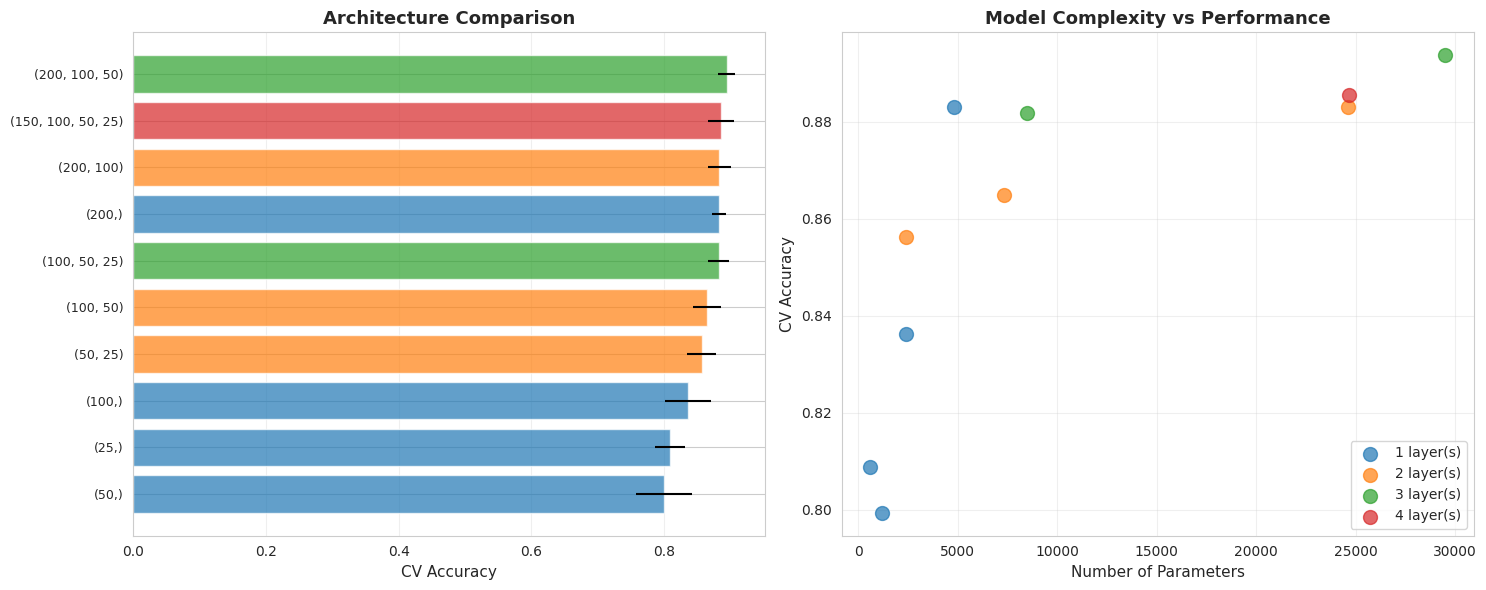

In [4]:
# アーキテクチャ結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CVスコア
df_sorted = df_arch.sort_values('CV Mean')
colors = ['C0' if d==1 else 'C1' if d==2 else 'C2' if d==3 else 'C3' for d in df_sorted['Depth']]

axes[0].barh(range(len(df_sorted)), df_sorted['CV Mean'], 
             xerr=df_sorted['CV Std'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(df_sorted)))
axes[0].set_yticklabels(df_sorted['Architecture'], fontsize=9)
axes[0].set_xlabel('CV Accuracy', fontsize=11)
axes[0].set_title('Architecture Comparison', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# パラメータ数 vs 性能
for depth in [1, 2, 3, 4]:
    subset = df_arch[df_arch['Depth'] == depth]
    axes[1].scatter(subset['Parameters'], subset['CV Mean'], 
                    s=100, label=f'{depth} layer(s)', alpha=0.7)

axes[1].set_xlabel('Number of Parameters', fontsize=11)
axes[1].set_ylabel('CV Accuracy', fontsize=11)
axes[1].set_title('Model Complexity vs Performance', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 3. 学習率とAlphaの探索

ヒートマップで相互作用を可視化します。

Running grid search...


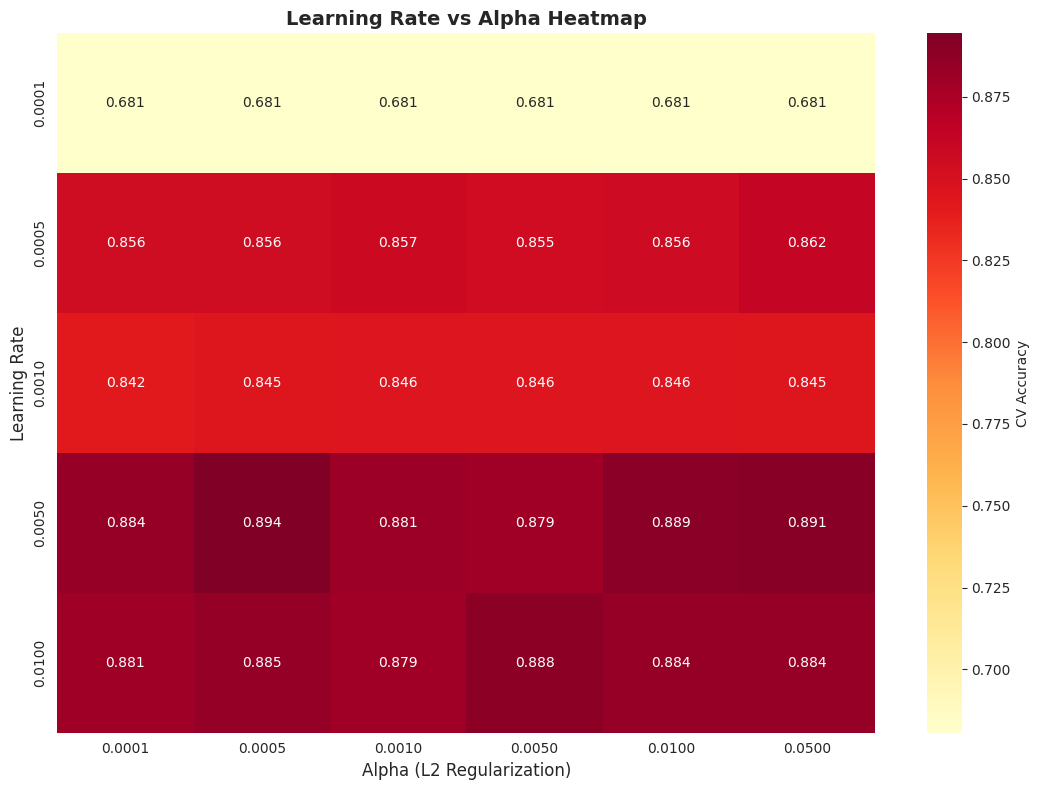


Best combination:
  Learning rate: 0.005
  Alpha: 0.0005
  CV Accuracy: 0.8944


In [5]:
# 学習率 vs Alpha のグリッド探索
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

results_grid = np.zeros((len(learning_rates), len(alphas)))

print("Running grid search...")
for i, lr in enumerate(learning_rates):
    for j, alpha in enumerate(alphas):
        mlp = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=500,
            early_stopping=True,
            random_state=42
        )
        cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=3, scoring='accuracy')
        results_grid[i, j] = cv_scores.mean()

# ヒートマップ
plt.figure(figsize=(11, 8))
sns.heatmap(results_grid, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[f'{a:.4f}' for a in alphas],
            yticklabels=[f'{lr:.4f}' for lr in learning_rates],
            cbar_kws={'label': 'CV Accuracy'})
plt.xlabel('Alpha (L2 Regularization)', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate vs Alpha Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

best_idx = np.unravel_index(np.argmax(results_grid), results_grid.shape)
print(f"\nBest combination:")
print(f"  Learning rate: {learning_rates[best_idx[0]]}")
print(f"  Alpha: {alphas[best_idx[1]]}")
print(f"  CV Accuracy: {results_grid[best_idx]:.4f}")

---

## 4. GridSearchCVによる包括的探索

In [6]:
# パラメータグリッドの定義
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_base = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

grid_search = GridSearchCV(
    mlp_base,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("Starting GridSearchCV...")
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.score(X_test_scaled, y_test):.4f}")

Starting GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits



GRID SEARCH RESULTS

Best Parameters:
  activation: relu
  alpha: 0.01
  hidden_layer_sizes: (100,)
  learning_rate_init: 0.01

Best CV Score: 0.8944
Test Score: 0.9025


In [7]:
# Top 10の組み合わせを表示
results_df = pd.DataFrame(grid_search.cv_results_)
cols = ['param_hidden_layer_sizes', 'param_activation', 'param_alpha',
        'param_learning_rate_init', 'mean_test_score', 'std_test_score',
        'mean_train_score', 'rank_test_score']
results_summary = results_df[cols].sort_values('rank_test_score')

print("\nTop 10 Parameter Combinations:")
print(results_summary.head(10).to_string(index=False))


Top 10 Parameter Combinations:
param_hidden_layer_sizes param_activation  param_alpha  param_learning_rate_init  mean_test_score  std_test_score  mean_train_score  rank_test_score
               (100, 50)             relu       0.0100                      0.01         0.894375        0.014170          0.989687                1
                  (100,)             relu       0.0100                      0.01         0.894375        0.014711          0.978594                1
                  (100,)             relu       0.0001                      0.01         0.893750        0.015934          0.975781                3
                  (100,)             relu       0.0010                      0.01         0.892500        0.015637          0.976094                4
                (50, 25)             relu       0.0001                      0.01         0.891250        0.016226          0.978906                5
               (100, 50)             relu       0.0001                    

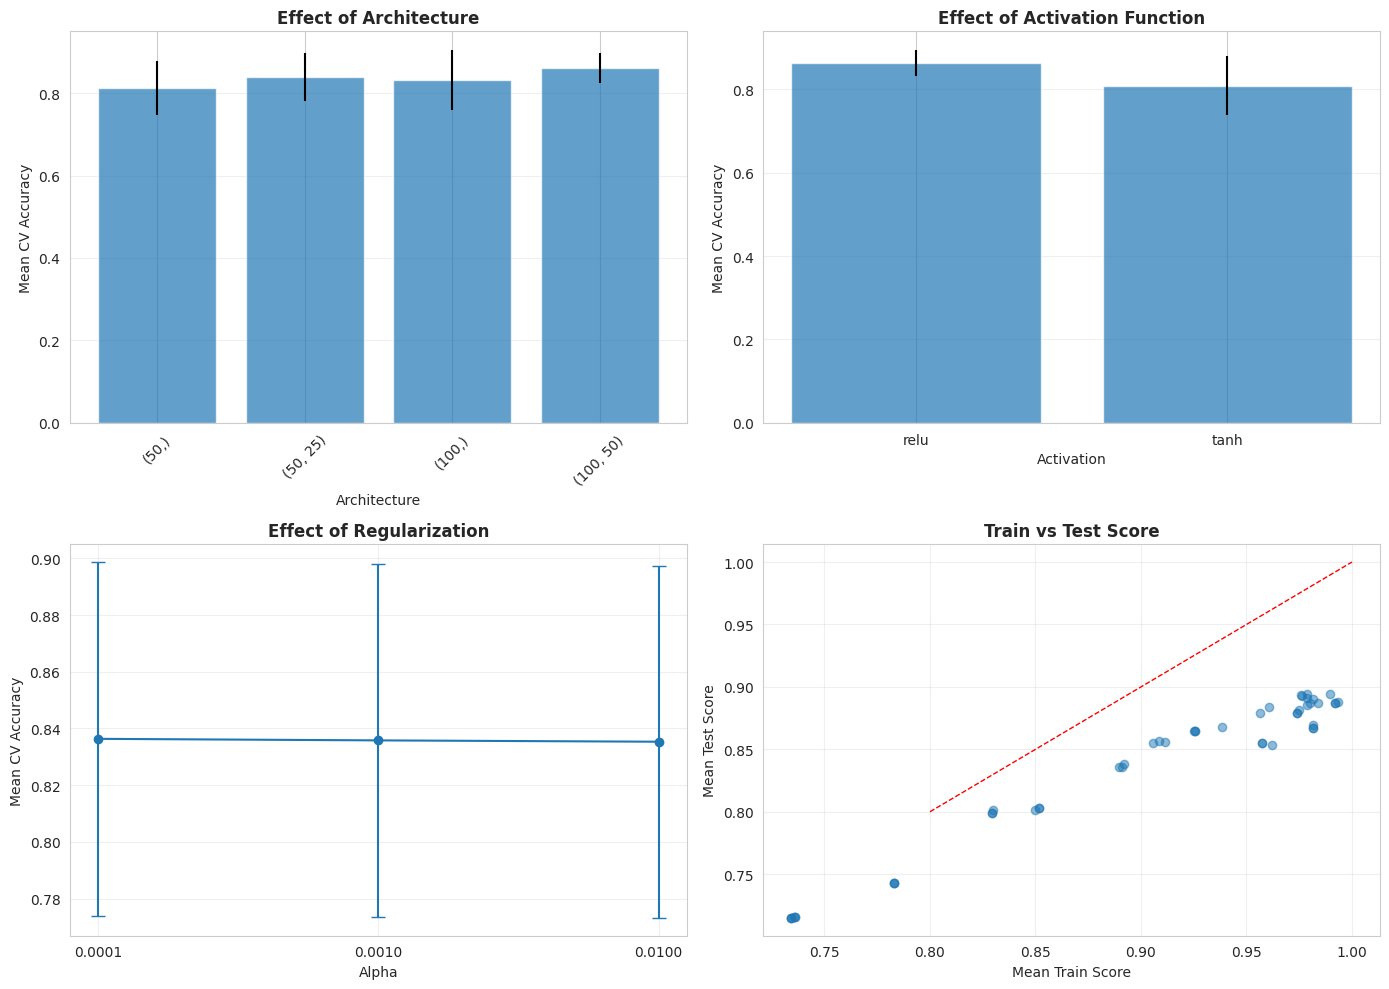

In [8]:
# GridSearch結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# アーキテクチャの影響
arch_results = results_df.groupby('param_hidden_layer_sizes')['mean_test_score'].agg(['mean', 'std'])
arch_labels = [str(a) for a in arch_results.index]
axes[0, 0].bar(arch_labels, arch_results['mean'], yerr=arch_results['std'], alpha=0.7)
axes[0, 0].set_xlabel('Architecture', fontsize=10)
axes[0, 0].set_ylabel('Mean CV Accuracy', fontsize=10)
axes[0, 0].set_title('Effect of Architecture', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 活性化関数の影響
act_results = results_df.groupby('param_activation')['mean_test_score'].agg(['mean', 'std'])
axes[0, 1].bar(act_results.index, act_results['mean'], yerr=act_results['std'], alpha=0.7)
axes[0, 1].set_xlabel('Activation', fontsize=10)
axes[0, 1].set_ylabel('Mean CV Accuracy', fontsize=10)
axes[0, 1].set_title('Effect of Activation Function', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Alphaの影響
alpha_results = results_df.groupby('param_alpha')['mean_test_score'].agg(['mean', 'std'])
axes[1, 0].errorbar(range(len(alpha_results)), alpha_results['mean'],
                    yerr=alpha_results['std'], marker='o', capsize=5)
axes[1, 0].set_xticks(range(len(alpha_results)))
axes[1, 0].set_xticklabels([f'{a:.4f}' for a in alpha_results.index])
axes[1, 0].set_xlabel('Alpha', fontsize=10)
axes[1, 0].set_ylabel('Mean CV Accuracy', fontsize=10)
axes[1, 0].set_title('Effect of Regularization', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Train vs Test
axes[1, 1].scatter(results_df['mean_train_score'], results_df['mean_test_score'], alpha=0.5)
axes[1, 1].plot([0.8, 1], [0.8, 1], 'r--', lw=1)
axes[1, 1].set_xlabel('Mean Train Score', fontsize=10)
axes[1, 1].set_ylabel('Mean Test Score', fontsize=10)
axes[1, 1].set_title('Train vs Test Score', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. RandomizedSearchCVで大規模探索

In [9]:
# パラメータ分布の定義
param_distributions = {
    'hidden_layer_sizes': [
        (50,), (100,), (200,),
        (50, 25), (100, 50), (200, 100),
        (100, 50, 25), (200, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': loguniform(1e-5, 1e-1),
    'learning_rate_init': loguniform(1e-4, 1e-1),
    'batch_size': [32, 64, 128, 256]
}

mlp_random = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

random_search = RandomizedSearchCV(
    mlp_random,
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("RANDOMIZED SEARCH RESULTS")
print("="*60)
print("\nBest Parameters:")
for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

print(f"\nBest CV Score: {random_search.best_score_:.4f}")
print(f"Test Score: {random_search.score(X_test_scaled, y_test):.4f}")

Starting RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits



RANDOMIZED SEARCH RESULTS

Best Parameters:
  activation: relu
  alpha: 0.004735
  batch_size: 32
  hidden_layer_sizes: (200,)
  learning_rate_init: 0.005941

Best CV Score: 0.8919
Test Score: 0.9150


---

## 6. 学習曲線の分析

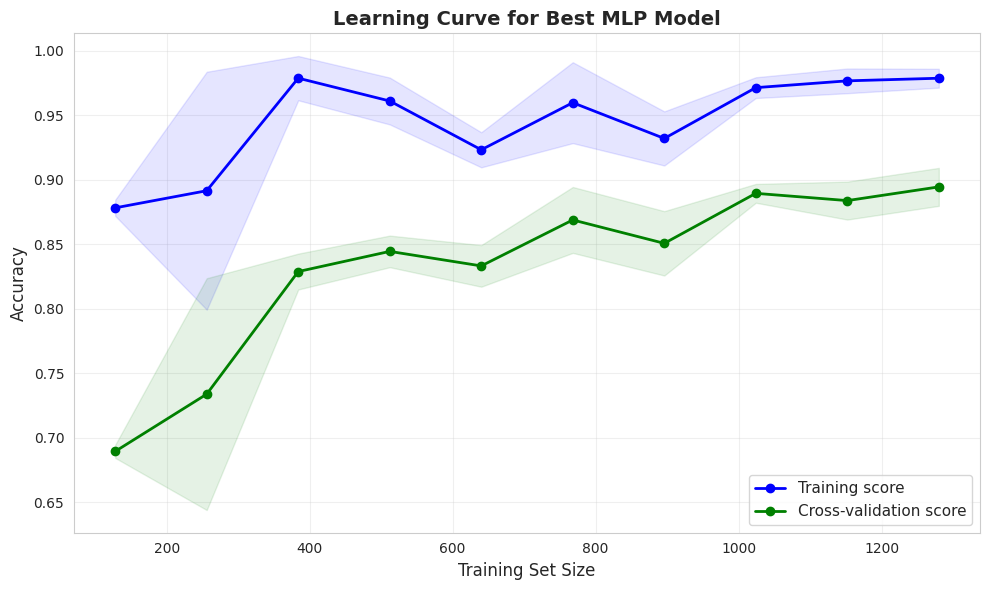

Learning Curve Analysis:
- Training and validation curves converge: Good fit
- Large gap between curves: Overfitting
- Both curves plateau at low score: Underfitting


In [10]:
# 最良モデルで学習曲線を生成
best_model = grid_search.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score', linewidth=2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                 alpha=0.1, color='green')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Learning Curve for Best MLP Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Learning Curve Analysis:")
print("- Training and validation curves converge: Good fit")
print("- Large gap between curves: Overfitting")
print("- Both curves plateau at low score: Underfitting")

---

## まとめ

### パラメータチューニングの戦略

1. **段階的アプローチ**
   - まずアーキテクチャを決定
   - 次に学習率とalphaを調整
   - 最後に細かいパラメータを微調整

2. **GridSearchCV vs RandomizedSearchCV**
   - GridSearchCV: 小規模パラメータ空間
   - RandomizedSearchCV: 大規模パラメータ空間

3. **重要なパラメータ**
   - `hidden_layer_sizes`: アーキテクチャ
   - `alpha`: 正則化強度
   - `learning_rate_init`: 学習率
   - `activation`: 活性化関数

4. **診断ツール**
   - ヒートマップ: パラメータ相互作用
   - 学習曲線: 過学習/未学習
   - クロスバリデーション: 汎化性能

### ベストプラクティス

1. 常にクロスバリデーションを使用
2. Early stoppingを有効化
3. 学習曲線で診断
4. ヒートマップで可視化
5. テストセットは最後に評価

---

**次のステップ**: ノートブック09で、MLPを回帰問題と時系列予測に適用します!
